# Regression IV (Study notes)

## 1 - Introdução

#### Limitações do modelo

Temos sempre que avaliar as limitações dos nossos modelos à luz dos objetivos do projeto. No frigir dos ovos, são os objetivos que vão determinar se uma limitação é relevante ou não, e é sob essa ótica que vamos analisar as situações de limitação mais importantes que separamos neste módulo.

#### Objetivos

Toda avaliação de risco de modelos e de limitações do modelo deve ser feita com base nos objetivos e usos dele. Dessa forma, a primeira limitação que vou mencionar é a de escopo.

**Amostra e escopo**:<br>


Um atleta que treinou para *100 metros rasos* somente vai ser competitivo em *salto em altura* se fizer **outro** treinamento específico. O mesmo ocorre com um modelo. Se fizermos um modelo para um objetivo específico, não podemos esperar o melhor desempenho para outro objetivo.

Um modelo construído para um determinado público deve ter uma amostra representativa desse público da forma mais fiel possível (embora nem sempre é possível a amostra ser 100% fiel). Desvios de representatividade da amostra com relação ao público alvo representam uma extrapolação que pode ter efeitos imprevisíveis.

**Aplicação cruzada**:<br>


Por vários motivos é relativamente comum ver modelos sendo desenvolvidos em um público e aplicados a outro. Em uma operação de crédito sobre um produto novo, por exemplo, pode não haver histórico suficiente para se construir um modelo específico para aquele produto, de modo que não há muitas alternativas melhores. Essas aplicações cruzadas podem ser muito bem sucedidas, mas os desvios da expectativa são imprevisíveis. Por esse motivo é sempre um desafio grande iniciar uma operação de crédito em um produto novo.

**Alterações na população**:<br>


No entanto, nosso modelo é epecífico para um determinado público, **em um determinado período**, com uma taxa base de juros, um índice de desemprego e um entorno sócio-econômico espefícos. Essas situações se alteram, bem como outras que nem conseguimos medir, o que pode causar alterações na população, e portanto, alterações no funcionamento do modelo. 

Estamos sujeitos a construir um modelo que perde a validade com o tempo - aliás devemos até esperar por isso, e fazer monitoramentos dos nossos modelos de modo tomar ações tempestivamente. Esse assunto vai ser coberto ainda em outro módulo com mais detalhes, por hora saiba que é bastante comum e esperado observarmos alterações na população, ou *drifts* no modelo.

**Componentes do modelo**

Em um artigo influente, os reguladores OCC e FED afirmam que um modelo é composto de três componentes:

- Um componente de input de informações, que entrega suposições e dados ao modelo
- Um componente de processamento que transforma inputs em estimativas
- Um componente de *report* que traduz as estimativas em informações de negócio úteis.

Vamos dar foco aqui sobre a componente de processamento do modelo, mas devemos estar atentos às outras componentes, pois qualquer problema nelas pode inviabilizar todo o bonito desenvolvimento que realizamos.

## 2 - Suposições



##### Suposições do modelo

A regressão, vista como um modelo estatístico, é um modelo paramétrico, ou seja, nele se supõe uma distribuição de probabilidades específica para os dados. É verdade que esta distribuição é, normalmente, a mais razoável para variáveis contínuas, e dependendo do que queremos fazer, o teorema central do limite nos protege para muitos usos.

Nosso objetivo nesta aula é refletir sobre essas suposições, as implicações de não cumprimento dessas suposições.

**Estrutura**

O modelo de regressão múltipla clássico tem essa forma:

$$y_i \sim \alpha + \beta_1 x_{i,1}+ \beta_2 x_{i,2}+...+ \beta_p x_{i,p} + \epsilon_i $$

com:

- $y_i$ é a variável resposta, endógena ou dependente. É ela que vamos explicar/prever com base nas demais variáveis
- $x_{i,j}$ são as variáveis explicativas, exógenas ou dependentes (é tudo siônimo). Cada $x_{i,j}$ é o valor da variável $j$ para o indivíduo $i$ com $i=1, 2,...n$ e $j=1, 2, ... p$.
- $\alpha$ é uma constante, que representa o valor médio de $y$ quando todos os $x$ são iguais a zero.
- $\beta_j$ são constantes que podem ser interpretadas como o aumento em $y$ para cada unidade do respectivo $x_j$ que aumentamos.
- $\epsilon$ é um erro aleatório dado pela diferença entre o valor $y_i$ e o seu respectivo valor médio $E(y_i)$ dado pelo modelo de regressão.

As suposições estatísticas dessa regressão são:

- Independência: $\epsilon_i$ são independentes entre sí
- Distribuição Normal: $\epsilon_i \sim N(0,\sigma_m)$ com i=1, 2,... n e $\sigma_m$ é uma constante
- Homocedasticidade: $\epsilon_i$ possuem todos a mesma variância $\sigma_m^2$

Vamos começar por essas três suposições e ponderar sobre os impactos de não cumprimento.

In [1]:
# Bibliotecas

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# Carregando dados 
df = sns.load_dataset('tips').dropna()
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
# Definindo novas variáveis
df['tip_pct'] = df['tip'] / (df['total_bill'] - df['tip'])
df['log_tip'] = np.log(df['tip'])
df['log_bill'] = np.log(df.total_bill)
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204,0.009950,2.832625
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244,0.506818,2.336020
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886,1.252763,3.044999
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494,1.196948,3.164631
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069,1.283708,3.202340


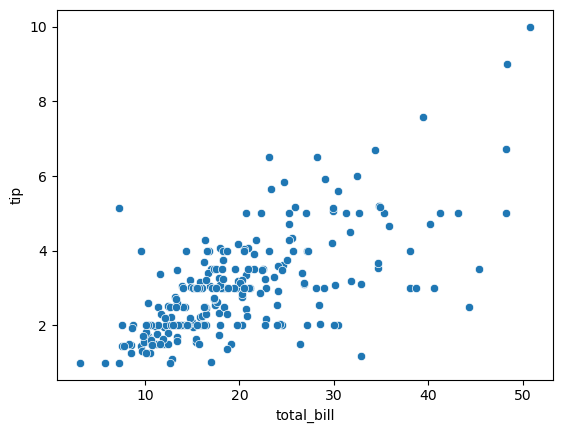

In [4]:
sns.scatterplot(y='tip', x='total_bill', data=df[df.tip_pct < 11.5]);

In [5]:
# Aplicando uma regressão simples

reg = smf.ols('tip ~ total_bill', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           6.69e-34
Time:                        09:09:31   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9203      0.160      5.761      0.000       0.606       1.235
total_bill     0.1050      0.007     14.260      0.000       0.091       0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independência

A forma mais prática de verificar a independência é pelo **gráfico de resíduos**. Os resíduos não devem apresentar qualquer tipo de padrão com relação a qualquer outra variável. As checagens mais comuns são através da observação de gráficos de resíduos versus:

- A ordem dos dados
- Valores preditos
- Variáveis explicativas
- Qualquer outra variável

Fontes comuns de dependência podem ser encontradas na estrutura de coleta dos dados, por exemplo se há várias medidas de um mesmo indivíduo, se há grupos familiares ou outros fatores que possam relacionar as observações. Se os resíduos para o mesmo indivíduo apresentarem algum tipo de padrão, significa que a independência está sendo violada.

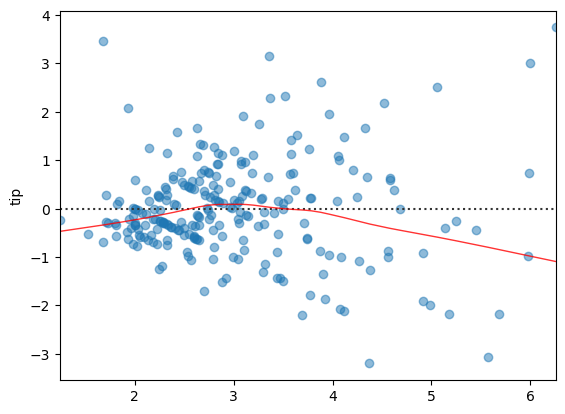

In [6]:
# Plotando uma gráfico para os resíduos em relação à gorjeta

sns.residplot(x=reg.predict(), y='tip', data=df, 
              lowess=True, # Curva vermelha (indica se há padrão nos dados - abordagem de regressão)
              scatter_kws={'alpha':.5}, 
              line_kws={'color':'red', 'lw':1, 'alpha':.8});

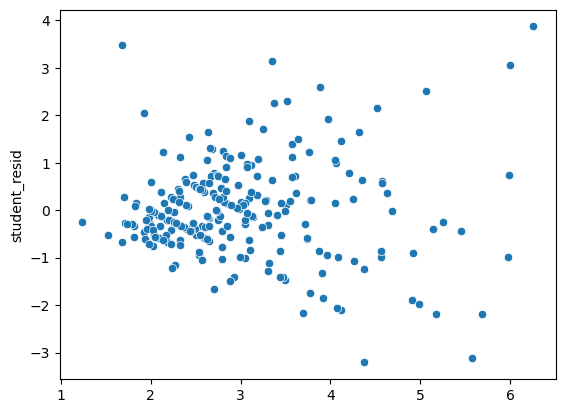

In [7]:
# Resíduo Student (para padronizar os resíduos com variância 1)
# Valores acima de 2 são altos e acima de 3 muito altos

st_res = reg.outlier_test() 
sns.scatterplot(x = reg.predict(), 
                y = st_res.student_resid); # para obter o resíduo de Student

#### Distribuição Normal

**Pra que é importante?**<br>
Essa suposição é importante para garantir que os estimadores tenham as distribuições estudadas. Com fugas da distribuição normal podem não valer mais as inferências sobre os parâmetros e sobre a variável resposta para novas observações.

**Impactos**<br>
Primeiramente, observo que não é um grande pecado violar a normalidade quando o nosso objetivo é fazer previsões. Se os resíduos não tiverem distribuição normal vão estar comprometidas as inferências sobre o *erro padrão* das previsões (principalmente), e também sobre os erros padrão dos parâmetros. Lembrando que estes últimos são mais protegidos pelo teorema central do limite, de modo que para amostras grandes haverá uma interferência um pouco menor.

**Verificação**<br>
A checagem dessa distribuição é feita basicamente em se avaliando os resíduos. O resíduo *ordinário* é simplesmente $y_i-\hat{y}_i$, mas há uma variedade de outras proposições de resíduos também.

Vamos falar também do *studentized residual*, que é o resíduo dividido pelo seu erro padrão. Se todas as suposições da regressão estão atendidas, ele tem distribuição normal padrão, o que torna conveniente de se avaliar a sua amplitude - por exemplo, **esperamos que a maioria dos resíduos estejam entre -2 e 2, e muito poucos mesmo estejam fora do intervalo \[-3, 3\]**.

**Medidas corretivas** <br>
Um caso comum de fuga dessa suposição é quando temos assimetria nos dados. Uma medida **corretiva popular é transformar a variável resposta (target) com uma função ```log```**, o que corrige em grande parte dos casos a distribuição. Além disso, há opções de modelos mais robustos que ainda permitem os testes, mas não vamos abordá-los aqui.

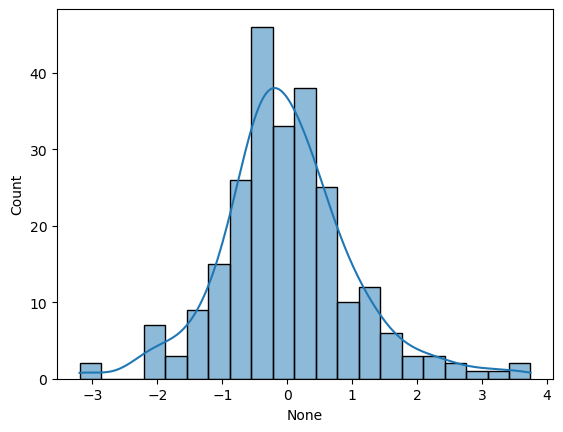

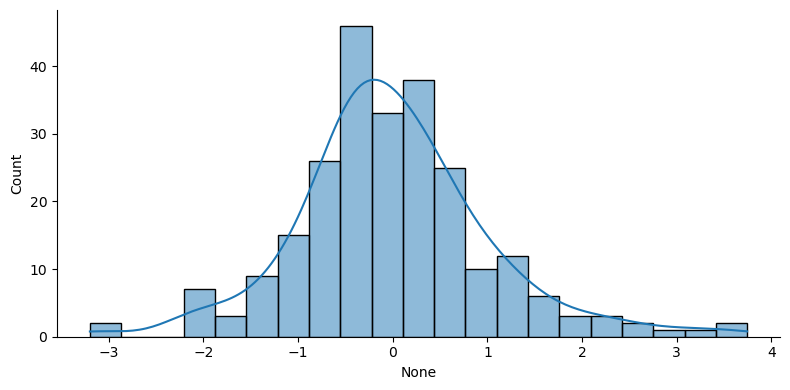

In [8]:
# Verificando a distribuição normal por meio de um histograma dos resíduos

sns.histplot(x=reg.resid, kde=True);

#ou
sns.displot(x = reg.resid, height=4, aspect=2, kde=True);

#### Mesma variância

**Impactos**<br>
Novamente, a falha desta suposição pode comprometer somente o erro padrão dos estimadores (e da variância das previsões) - mas não a acurácia da previsão pontual. No entanto, essa é uma das suposições mais importantes, dado que o teorema central do limite não protege muito nesse caso.

**Verificação**<br>
A principal análise para se **verificar a homocedasticidade** (mesma variância na regressão, para todas as previsões) é um **gráfico dos resíduos versus o valor predito**. Um comportamento problemático típico é uma forma de 'cone' no gráfico.

**Correções**<br>
Novamente a transformação ```log``` costuma resolver boa parte dos casos em que temos *heterocedasticidade*, pois o log transforma uma estrutura multiplicativa em aditiva. Por exemplo, se temos dados financeiros, pode ser razoável observarmos uma variância de 10% do valor médio. Em um caso desses, a transformação ```log``` vai fornecer bons resultados.

Há também modelos específicos robustos para isto, os quais estão fora do nosso escopo.

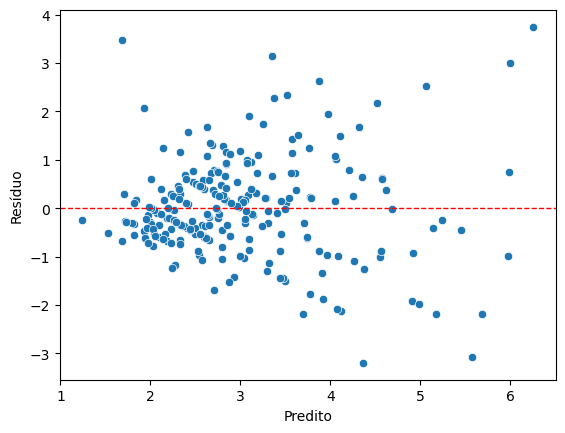

In [9]:
sns.scatterplot(x = reg.predict(), y = reg.resid)
plt.xlabel('Predito')
plt.ylabel('Resíduo')
plt.axhline(y=0, lw=1, ls='--', color='red')
plt.show()

## 3 - Outliers

**Impactos**<br>
Esse potencial problema pode causar efeitos não somente nos testes de hipóteses que estejamos interessados, mas também nas previsões, pois podem distorcer os resultados. Este é um tema com uma certa polêmica em torno, por ter uma boa carga de subjetividade no tratamento, de modo que, mais importante do que você aprender o que eu faço, é você conseguir ter uma opnião própria sobre a sua análise.

**Detecção**<br>
Outliers representam um problema em potencial, mas o fato de existirem não quer dizer que o modelo estará comprometido. O problema maior que eles podem causar é se forem também um 'ponto de alavanca' ou 'ponto influente' na regressão. Isso quer dizer que a presença desse ponto pode alterar de forma significativa a inclinação da regressão.

As técnicas que veremos visam buscar pontos influentes no modelo. Observe que quanto maior o tamanho da população, menor tende a ser a influência de um único ponto. Este ponto, embora pertença à população alvo, pode ter uma influência no modelo de modo que tenhamos um modelo menos generalizável, ou seja, com pior desempenho em uma base de teste, ou em uso.

**Correções**<br>
As correções mais comuns quando se encontram outliers são:

- Eliminação: simplesmente eliminar os pontos inconvenientes. Isso em geral deve ser feito com um certo cuidado, até por que, na vida real estamos sujeitos a encontrar pontos assim. Ao eliminar um outlier temos que responder afirmativamente à seguinte pergunta: "meu modelo está melhor sem esse outlier?".
- Truncagem: Consiste em 'forçar' o ponto de máximo a um valor específico. Isso causa efeitos colaterais no modelo, mas para a aplicação, valores absurdamente altos terão um efeito 'máximo' controlado nas previsões. Ajuda a limitar o efeito de extrapolações na implantação.

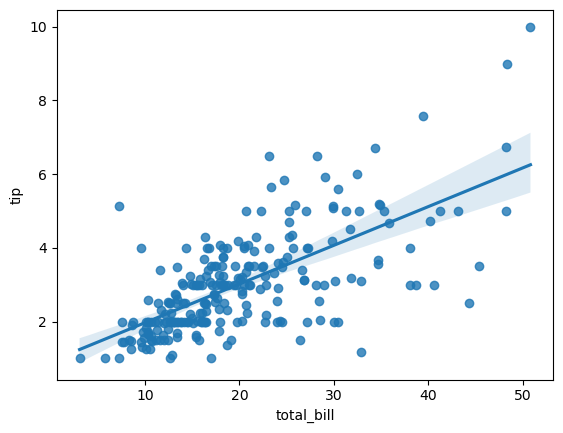

In [10]:
fig, ax = plt.subplots()

sns.regplot(x='total_bill', y='tip', data=df, ax=ax);

Note os pontos que se destacam dos demais (bivariados).

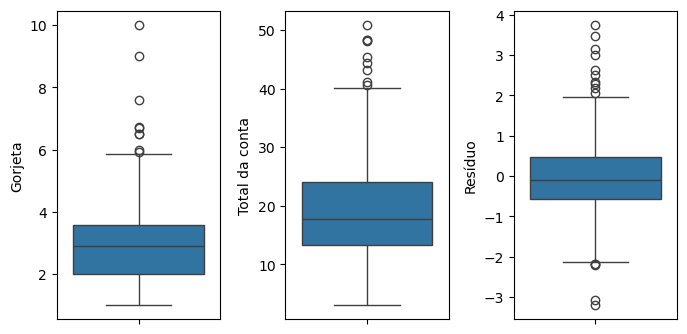

In [11]:
# Uma análise univariada

fig, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y='tip', data=df, ax=ax[0])
sns.boxplot(y='total_bill', data=df, ax=ax[1])
sns.boxplot(y=reg.resid, data=df, ax=ax[2])

ax[0].set_ylabel('Gorjeta')
ax[1].set_ylabel('Total da conta')
ax[2].set_ylabel('Resíduo');

É válido destacar que as circunferências acima e abaixo das barras horizontais (limite superior e inferior) indicam potenciais **outliers**.

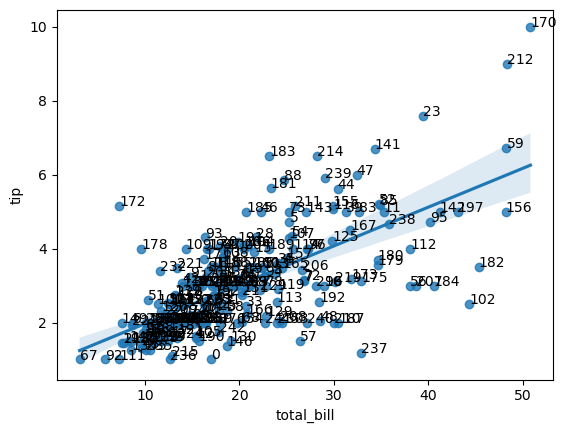

In [12]:
# façamos novamente o regplot enumerando os indíces dos pontos
fig, ax = plt.subplots()
sns.regplot(x = 'total_bill', y = 'tip', data=df, ax=ax)

for i, txt in enumerate(df.index.values):
    ax.annotate(str(txt), (df.loc[i, 'total_bill'], df.loc[i, 'tip']))

In [13]:
df[df.index == 170]

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
170,50.81,10.0,Male,Yes,Sat,Dinner,3,0.245038,2.302585,3.928093


In [14]:
df[df.index == 172]

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
172,7.25,5.15,Male,Yes,Sun,Dinner,2,2.452381,1.638997,1.981001


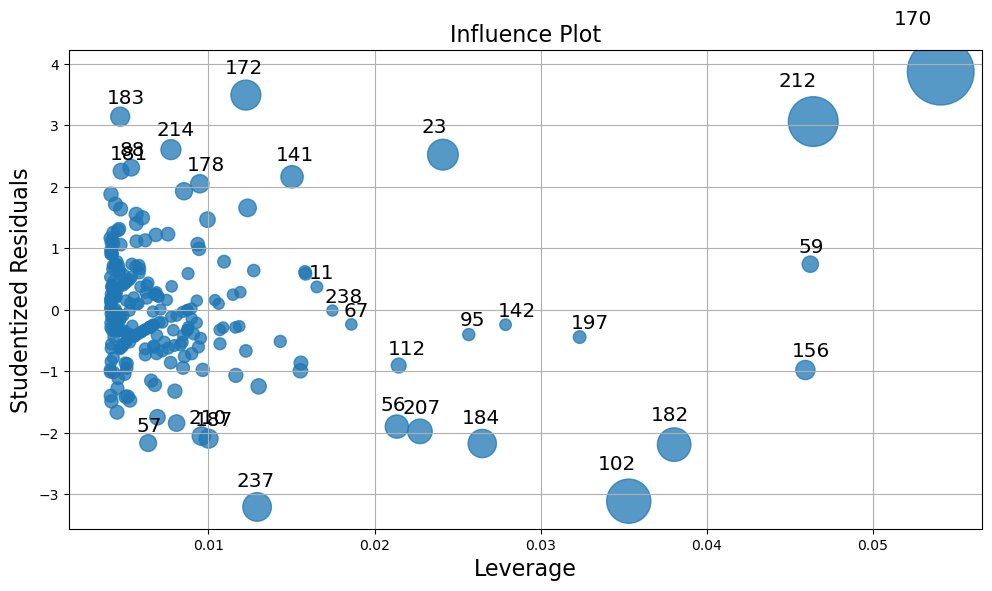

In [15]:
# Utilizando o módulo gráfico do statsmodels

reg = smf.ols('tip ~ total_bill', data = df).fit()

#influence_plot --> Gera um resíduo studantzado
#             O tamanho do círculo relaciona a influência do ponto na análise 
#             Laverage indica a alavanca(gem) da reta da regressão, ou seja, quanto mais ao extremo,
#             maior a influência

fig, ax = plt.subplots(figsize=[10,6])
fig = sm.graphics.influence_plot(reg, criterion='cooks', ax=ax)
fig.tight_layout(pad=1.0)
ax.grid()

## 4 - Caso de correção

##### Corrigindo o modelo

Pelas análises conduzidas, vamos começar a correção do modelo aplicando uma transformação ```log``` na variável resposta. Mas atenção, pois essa transformação tem mudanças importantes na estrutura do modelo.

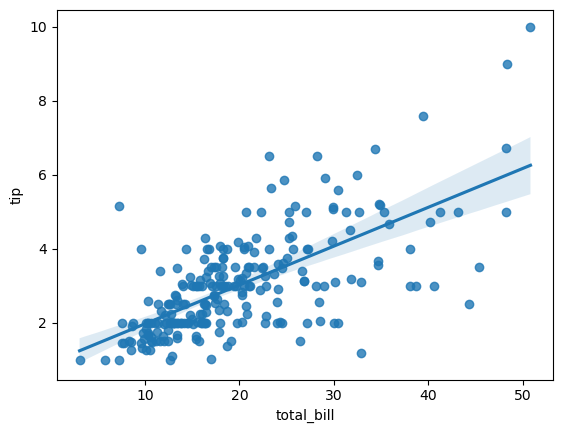

In [16]:
sns.regplot(y = 'tip', x = 'total_bill', data = df);

<Axes: xlabel='log_bill', ylabel='log_tip'>

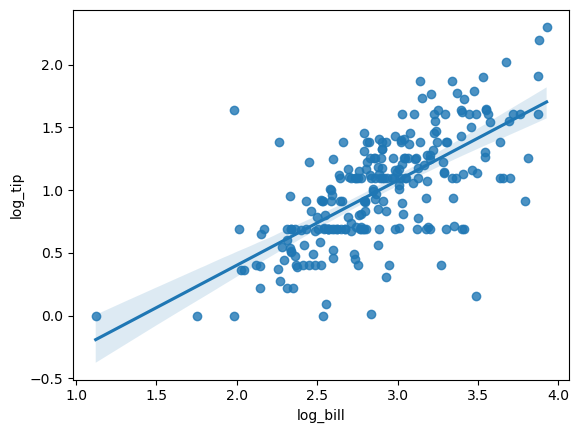

In [17]:
# Aplicando log nas variáveis
sns.regplot(y='log_tip', x='log_bill', data=df)

In [18]:
# Fazendo uma regressão

reg = smf.ols('log_tip ~ log_bill', data=df).fit()

##### Independência

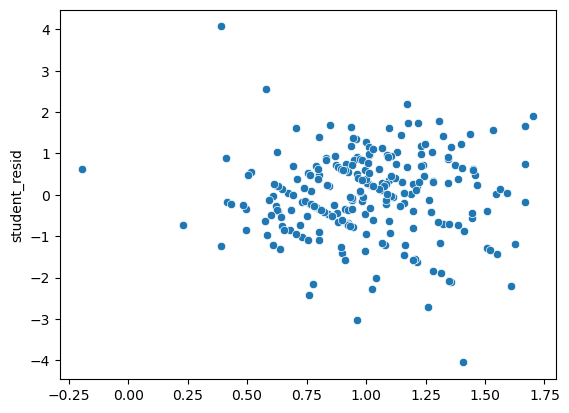

In [19]:
# Plot do predict e resíduo de Student
st_res = reg.outlier_test()
sns.scatterplot(x = reg.predict(), y = st_res.student_resid);

<Axes: ylabel='student_resid'>

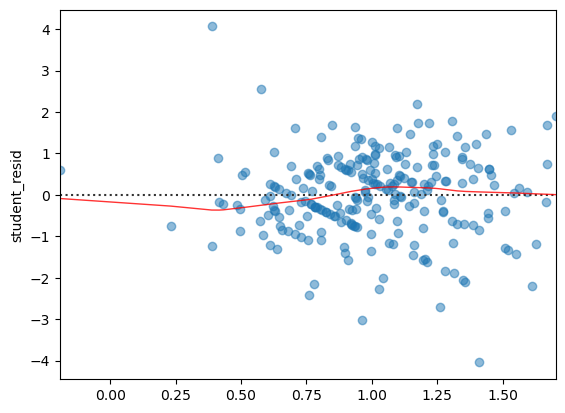

In [20]:
# Gerando um plot de resíduos

sns.residplot(x=reg.predict(), y=st_res.student_resid, lowess=True,
             scatter_kws = {'alpha': .5},
             line_kws = {'color': 'red', 'lw': 1, 'alpha': .8})

**Podemos também, analisar a independência avaliando a variável de resíduo de Student contra cada uma das variáveis que estão ou não no modelo.**

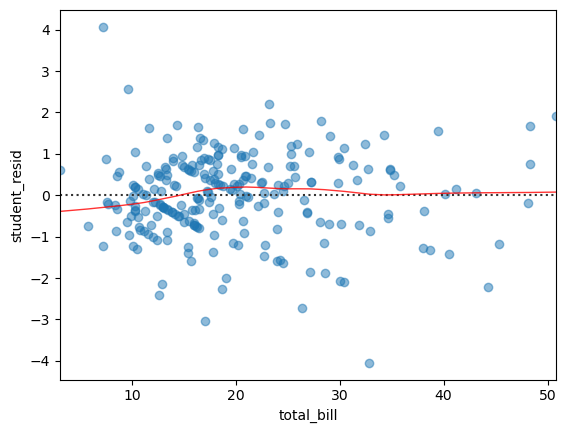

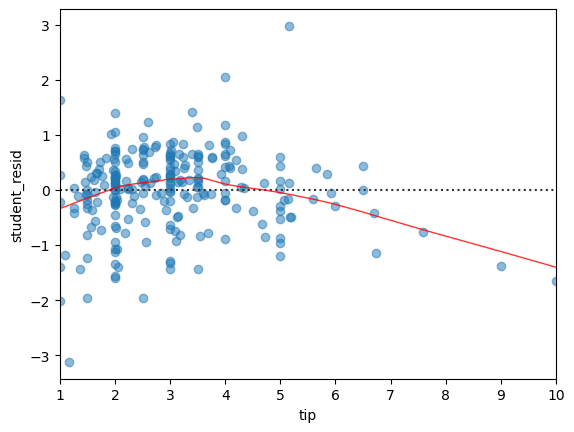

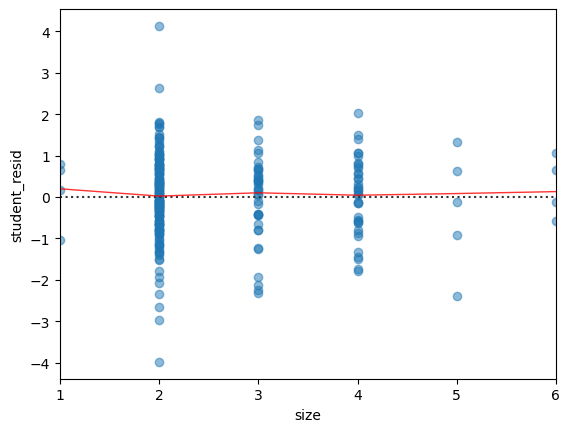

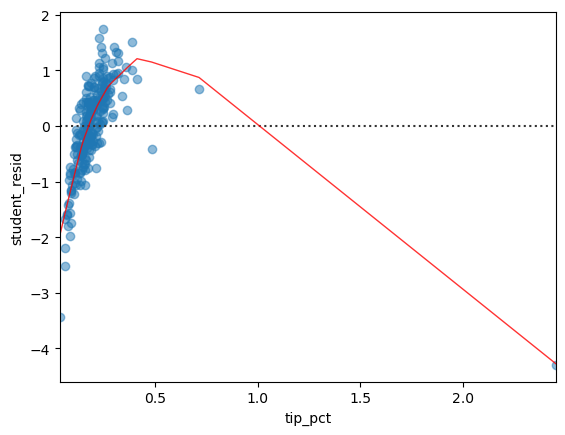

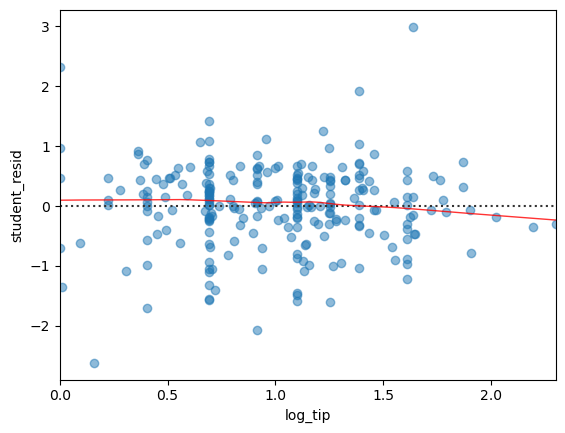

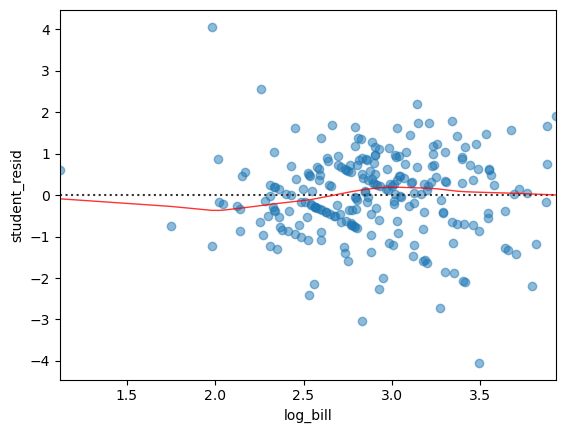

In [21]:
cols = list(df.select_dtypes('number').columns)

for col in cols: 
    sns.residplot(x=df[col], y=st_res.student_resid, lowess=True,
             scatter_kws = {'alpha': .5},
             line_kws = {'color': 'red', 'lw': 1, 'alpha': .8})
    plt.show()

#### Normal

Avaliando a distribuição normal.

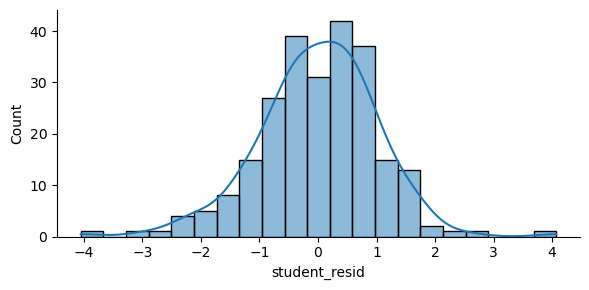

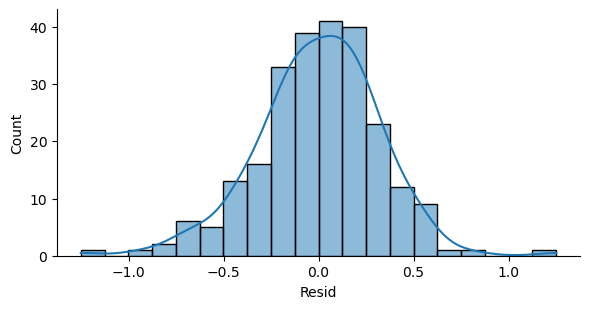

In [22]:
# utilizando o histograma do resíduo (normal ou studant)

# Resíduo Studant(zado)
sns.displot(st_res.student_resid, height=3, aspect=2, kde=True);

# resíduo 
sns.displot(reg.resid, height=3, aspect=2, kde=True)
plt.xlabel('Resid');

In [23]:
# Obtendo informações do summary

resumo = reg.summary()
resumo.tables[2]

Omnibus:,12.549,Durbin-Watson:,1.979
Prob(Omnibus):,0.002,Jarque-Bera (JB):,22.297
Skew:,-0.263,Prob(JB):,1.44e-05
Kurtosis:,4.385,Cond. No.,21.7


Teste: Jarque-Bera (JB) - Teste associado à normalidade dos resíduos.

##### Variância

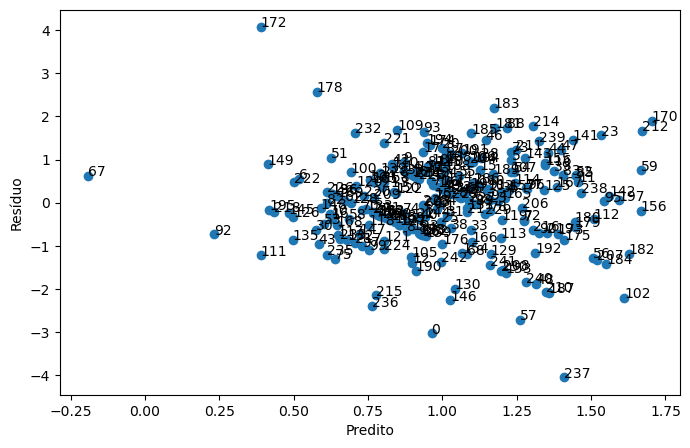

In [24]:
fig, ax = plt.subplots(figsize=[8,5])

st_res = reg.outlier_test()
ax.scatter(x = reg.predict(), y = st_res.student_resid)
ax.set_xlabel('Predito')
ax.set_ylabel('Resíduo')

for i, txt, in enumerate(df.index.values):
    ax.annotate(str(txt), (reg.predict()[i], st_res.student_resid[i]))

plt.show()

##### Pontos influentes

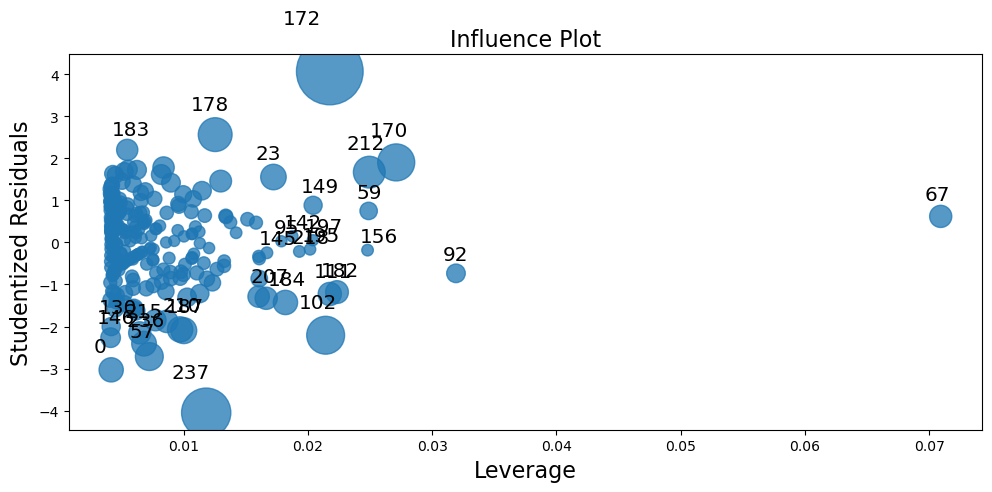

In [25]:
fig, ax = plt.subplots(figsize=[10,5])
fig = sm.graphics.influence_plot(reg, criterion='cooks', ax=ax)
fig.tight_layout(pad=1.0)

Os pontos que mais influenciam são 67, 172 e 237

In [26]:
# Vamos ordenar
# Uma vez que qualquer total_bill baixo com um valor razoavel de gorjeta gerará um tip_pct alto
# possibilitando a criação de um outlier

# Ponto 67
df.sort_values(by='total_bill').head().style.highlight_min(subset='total_bill')

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
67,3.070000,1.000000,Female,Yes,Sat,Dinner,1,0.483092,0.000000,1.121678
92,5.750000,1.000000,Female,Yes,Fri,Dinner,2,0.210526,0.000000,1.749200
111,7.250000,1.000000,Female,No,Sat,Dinner,1,0.160000,0.000000,1.981001
172,7.250000,5.150000,Male,Yes,Sun,Dinner,2,2.452381,1.638997,1.981001
149,7.510000,2.000000,Male,No,Thur,Lunch,2,0.362976,0.693147,2.016235


In [27]:
# Ordenando por tip_pct (pelos maiores percentual de gorjeta)

# Ponto 172
df.sort_values(by='tip_pct', ascending=False).head().style.highlight_max(subset='tip_pct')

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
172,7.250000,5.150000,Male,Yes,Sun,Dinner,2,2.452381,1.638997,1.981001
178,9.600000,4.000000,Female,Yes,Sun,Dinner,2,0.714286,1.386294,2.261763
67,3.070000,1.000000,Female,Yes,Sat,Dinner,1,0.483092,0.000000,1.121678
232,11.610000,3.390000,Male,No,Sat,Dinner,2,0.412409,1.220830,2.451867
183,23.170000,6.500000,Male,Yes,Sun,Dinner,4,0.389922,1.871802,3.142858


In [28]:
# Olhando agora para os menores percentuais de gojeta 

# Ponto 237
df.sort_values(by='tip_pct', ascending=True).head().style.highlight_min(subset='tip_pct')

,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
237,32.830000,1.170000,Male,Yes,Sat,Dinner,2,0.036955,0.157004,3.491343
102,44.300000,2.500000,Female,Yes,Sat,Dinner,3,0.059809,0.916291,3.790985
57,26.410000,1.500000,Female,No,Sat,Dinner,2,0.060217,0.405465,3.273743
0,16.990000,1.010000,Female,No,Sun,Dinner,2,0.063204,0.009950,2.832625
187,30.460000,2.000000,Male,Yes,Sun,Dinner,5,0.070274,0.693147,3.416414


##### Removendo algums pontos, como os selecionados e definindo cortes

In [29]:
df2 = df[(df['tip_pct'] < .45) & (df['tip_pct'] > .05)]

print(df2.shape)
df2.head()

(240, 10)


,total_bill,tip,sex,smoker,day,time,size,tip_pct,log_tip,log_bill
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204,0.009950,2.832625
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244,0.506818,2.336020
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886,1.252763,3.044999
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494,1.196948,3.164631
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069,1.283708,3.202340


In [30]:
# Regressão para tais dados
reg = smf.ols('log_tip ~ log_bill', data=df2).fit()

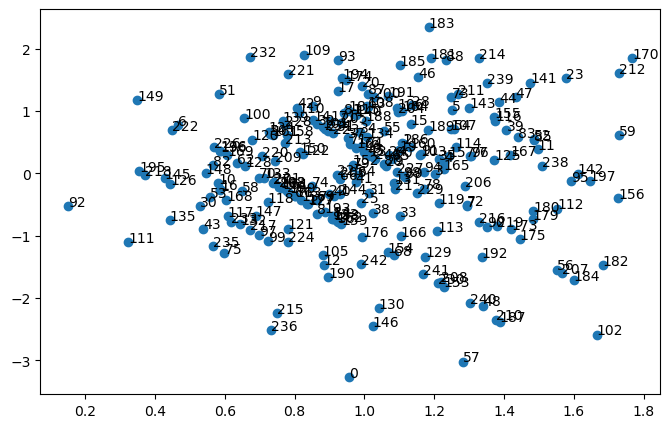

In [31]:
fig, ax = plt.subplots(figsize=[8,5])

st_res = reg.outlier_test()
ax.scatter(x = reg.predict(), y = st_res.student_resid)

for i, txt in enumerate(df2.index.values):
    ax.annotate(str(txt), (reg.predict()[i], st_res.student_resid.values[i]))

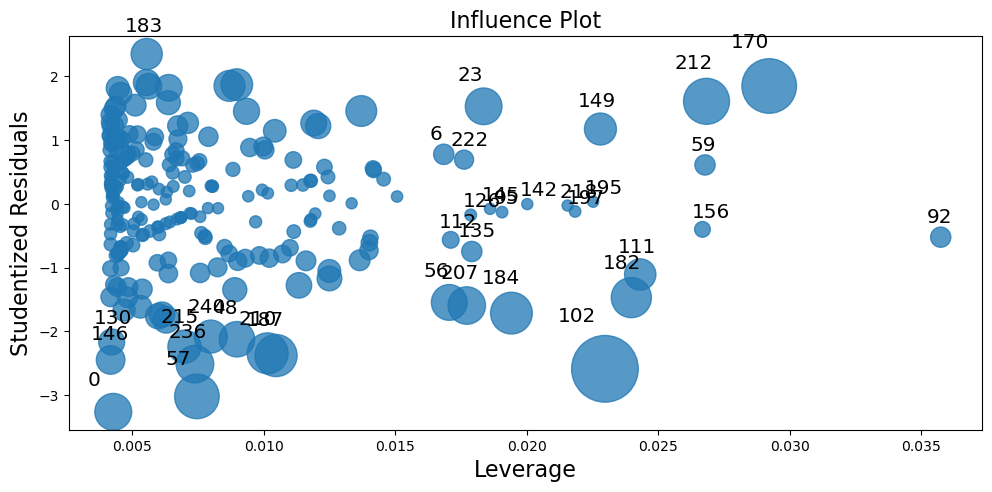

In [32]:
# Olhando novamente os pontos de influência

fig, ax = plt.subplots(figsize=[10,5])
fig = sm.graphics.influence_plot(reg, criterion='cooks', ax=ax)
fig.tight_layout(pad=1)

> 92 seria o novo ponto mais influente, uma vez que possui alto leverage.

In [33]:
# O sumário será
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_tip   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     263.1
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           2.36e-40
Time:                        09:09:37   Log-Likelihood:                -47.495
No. Observations:                 240   AIC:                             98.99
Df Residuals:                     238   BIC:                             106.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1432      0.134     -8.540      0.000      -1.407      -0.879
log_bill       0.7407      0.046     16.221      0.000       0.651       0.831
==============================================================================
Omnibus:                        9.305   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.312
Skew:                          -0.470   Prob(JB):                      0.00950
Kurtosis:                       3.217   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> **Note que com as remoção dos outliers obtivemos uma melhora no valor de R-quadrado.**

## 5 - Correlação nas explicativas - Multicolinearidade

É um fenômeno que ocorre quando temos variáveis explicativas muito correlacionadas. 

Possíveis efeitos:
- Quando variáveis possuem uma correlação muito alta (ex: uma é combinação linear das demais) 
- Pode alterar o erro padrão e os parâmetros das demais variáveis, resultando em parâmetros muito grandes e distorcidos, e até invertendo o sinal do parâmetro, indicando associação no sentido inverso
- Pode causar alterações mais leves nos parâmetros.

Em todos os casos, a multicolinearidade não afeta a previsão salvo em casos específicos.


In [34]:
# Carregando os dados 
penguins = sns.load_dataset('penguins').dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [35]:
variaveis = list(penguins.columns)
variaveis.remove('body_mass_g') # removendo a variável que iremos prever
variaveis

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'sex']

#### Medidas de associação

Medidas de associação podem ser muito úteis para se avaliar a multicolinearidade, pois pares de variáveis altamente correlacionados podem ser uma causa importante da multicolinearidade.

A medida mais básica é a correlação de Pearson, que mede associação entre duas variáveis contínuas. Essa medida varia de -1 a 1, quanto mais próxima de 1, maior a associação, quanto mais proxima de -1, maior a associação, mas em sentido negativo (x aumentar implica em y diminuir). E quanto mais próxima de zero, menor a associação (linear).

In [36]:
# Correlação de Pearson

penguins.select_dtypes('number').corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


A correlação de Pearson é ideal quando temos relação linear entre variáveis contínuas.

#### Correlação de *Spearman*

A correlação de *Spearman* é a correlação de Pearosn calculada nos *Ranks*.

O Rank é a posição ordinal correspondente ao valor da variável, calculamos asism:
- Ordenamos os valores da variável
- Atribuimos um valor sequencial correspondente aos valores ordenados
Ex: O menor valor tem *rank*=1, o segundo menor tem *rank*=2 e assim por diante.

**Características**:<br>
A correlação de Spearman tende a ser **mais robusta a outliers** e tende a captar algumas relações não lineares (sempre crescentes ou decrescentes) melhor que a correlação de Pearson.

In [37]:
# A correlação da correlação de Spearman

penguins.select_dtypes('number').corr(method='spearman')

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.213859,0.669754,0.576480
bill_depth_mm,-0.213859,1.000000,-0.517317,-0.429283
flipper_length_mm,0.669754,-0.517317,1.000000,0.840390
body_mass_g,0.576480,-0.429283,0.840390,1.000000


#### Coeficiente V de Cramer

Vulgarmente chamado de "correlação de Cramer", é mais precisamente uma medida de associação. Mede a associação entre variáveis qualitativas, baseado na estatística *qui-quadrado*.

- **Qui-quadrado**: A medida mais básica de associação entre variáveis qualitativas é a chamada "estatística qui-quadrado", construída a partir de uma tabela cruzada entre as duas variáveis. Sob $H_0$ (as variáveis são independentes), essa medida tem uma distribuição qui-quadrado. O problema é que essa medida não é muito intuitiva por variar de 0 a $+\infty$ e não é comparável entre tabelas de tamanhos diferentes. 

- **V de Cramer**: Baseada na estatística qui-quadrado, ela busca uma medida que seja comparável para qualquer tamanho de tabela cruzada e é mais intuitiva de se ler: varia entre 0 e 1, quanto mais próxima de 1, maior a associação e vice-versa.

O *v de Cramer* não está implementado em Python, mas abaixo há uma função que foi publicada no *Journal of the Korean Statistical Society*. 

In [38]:
def cramers_corrected_stat(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        return result

Esta é uma adaptação da função acima para funcionar para variáveis contínuas também. Como ela só funciona para variáveis qualitativas, ela categoriza a variável contínua para calcular a medida.

In [39]:
def cram(x, y, max_cat=5):
    if (np.dtype(x) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(x)) > max_cat):
            x_ = pd.qcut(x, max_cat)
#             print('#########')
    else: x_ = x
    if (np.dtype(y) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(y)) > max_cat):
            y_ = pd.qcut(y, max_cat)
    else: y_ = y
    return cramers_corrected_stat(x_ ,y_)

In [40]:
# testando
x = penguins.bill_depth_mm
y = penguins.island

cram(x, y, 5)

0.4542925122695079

> **Valor entre 0 e 1 (mínima e máxima, respectivamente), indicando que há ou não correlação.**

**Matriz de associação**

Agora vamos fazer uma matriz semelhante à matriz de correlação, e preenchê-la com o *v de Cramer*. Vamos iniciar um dataframe de zeros, fazer um loop duplo pelas variáveis, e preencher o dataframe com o valor do *v de Cramer* correspondente.

In [41]:
pd.DataFrame(np.zeros((len(variaveis),len(variaveis))), 
             columns=variaveis, 
             index=variaveis)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
species,0.0,0.0,0.0,0.0,0.0,0.0
island,0.0,0.0,0.0,0.0,0.0,0.0
bill_length_mm,0.0,0.0,0.0,0.0,0.0,0.0
bill_depth_mm,0.0,0.0,0.0,0.0,0.0,0.0
flipper_length_mm,0.0,0.0,0.0,0.0,0.0,0.0
sex,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Construir uma matriz vazia para acomodar as associações
matriz_cramer = pd.DataFrame(np.zeros((len(variaveis),len(variaveis))), 
             columns=variaveis, 
             index=variaveis)

# Calcular as associações
for var1 in variaveis:
    for var2 in variaveis:
        matriz_cramer.loc[var1, var2] = cram(penguins[var1], penguins[var2], 5)
        
matriz_cramer

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
species,1.000000,0.651031,0.648851,0.604221,0.684369,0.000000
island,0.651031,1.000000,0.292737,0.454293,0.480780,0.000000
bill_length_mm,0.648851,0.292737,1.000000,0.303280,0.379893,0.464269
bill_depth_mm,0.604221,0.454293,0.303280,1.000000,0.456997,0.542950
flipper_length_mm,0.684369,0.480780,0.379893,0.456997,1.000000,0.372006
sex,0.000000,0.000000,0.464269,0.542950,0.372006,1.000000


#### Variance Inflation Factor

O *Variance Inflation Factor* (ou VIF) é uma das medidas de multicolinearidade mais populares. Essa medida indica o quanto da variabilidade de uma variável é explicada pelas demais. Se as variáveis "se explicam" muito umas às outras, vamos ter multicolinearidade.

O VIF indica quanto de uma variável X(i) é explicada pelas demais, ele é construído assim:
- Faz-se um modelo de regressão para explicar X(i) (como resposta) com todas as demais X1, X2, etc (exceto X(i)) como explicativas
- Calculamos o $R^2$
- O VIF é $1/R^2$

Assim, um VIF igual a 20 significa que 95% da variabilidade é explicada pelas demais variáveis. VIF=10 corresponde a 90% de explicação da variância. Dessa forma ele serve de alerta.

**Medidas corretivas**<br>

A medida corretiva mais comum é utilizar apenas uma das variáveis no modelo. Podemos utilizar também a PCA, ou extrair a informação exclusiva da variável como veremos mais adiante.

In [43]:
print(variaveis)

peng_dum = pd.get_dummies(penguins[variaveis], 
                          drop_first=True, 
                          dtype=float # Definindo as variáveis como float
                         )
peng_dum.head()

['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex']


,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,0.0,0.0,0.0,1.0,1.0
1,39.5,17.4,186.0,0.0,0.0,0.0,1.0,0.0
2,40.3,18.0,195.0,0.0,0.0,0.0,1.0,0.0
4,36.7,19.3,193.0,0.0,0.0,0.0,1.0,0.0
5,39.3,20.6,190.0,0.0,0.0,0.0,1.0,1.0


É necessário converter as variáveis para **float** ou **int** (**bool** não parece ser funcional) antes do procedimento que segue

In [44]:
# Calculando FATOR DE INFLAÇÃO DA VARIÂNCIA

vif(peng_dum, 0), vif(peng_dum, 1), vif(peng_dum, 2), vif(peng_dum, 3) 

(389.9259822252421, 408.68652237783874, 652.987605852645, 5.832522866728055)

In [45]:
# Gerando um dataframe

vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(peng_dum, i) for i in range(peng_dum.shape[1])]
vars_vif["Feature"] = peng_dum.columns

vars_vif.round(2) # vifs muito altos indicam "problema"

,VIF Factor,Feature
0,389.93,bill_length_mm
1,408.69,bill_depth_mm
2,652.99,flipper_length_mm
3,5.83,species_Chinstrap
4,24.27,species_Gentoo
5,5.07,island_Dream
6,2.10,island_Torgersen
7,2.95,sex_Male


In [46]:
# Rodando um modelo com apenas uma das variáveis de alto vif
r1 = smf.ols('''
        body_mass_g ~ 
        species + sex + island
        + bill_length_mm
    ''', data=penguins.dropna()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     321.8
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          1.09e-133
Time:                        09:09:38   Log-Likelihood:                -2378.0
No. Observations:                 333   AIC:                             4770.
Df Residuals:                     326   BIC:                             4797.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2167.9043    277.202      7.821      0.000    1622.574    2713.235
species[T.Chinstrap]  -298.8631     94.422     -3.165      0.002    -484.616    -113.110
species[T.Gentoo]     1096.2997     83.136     13.187      0.000     932.749    1259.850
sex[T.Male]            547.3791     43.405     12.611      0.000     461.989     632.769
island[T.Dream]          1.5320     62.572      0.024      0.980    -121.564     124.628
island[T.Torgersen]      2.6153     64.794      0.040      0.968    -124.851     130.081
bill_length_mm          32.5353      7.346      4.429      0.000      18.083      46.987
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.229
Skew:                          -0.000   Prob(JB):                        0.892
Kurtosis:                       2.871   Cond. No.                         771.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Rodando um modelo com todas as variáveis
r1 = smf.ols('''
    body_mass_g ~ 
        species + sex + island
        + bill_length_mm
        + bill_depth_mm
        + flipper_length_mm
    ''', data=penguins.dropna()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     284.1
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          1.85e-141
Time:                        09:09:38   Log-Likelihood:                -2353.6
No. Observations:                 333   AIC:                             4725.
Df Residuals:                     324   BIC:                             4760.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1500.0291    575.822     -2.605      0.010   -2632.852    -367.207
species[T.Chinstrap]  -260.3063     88.551     -2.940      0.004    -434.513     -86.100
species[T.Gentoo]      987.7614    137.238      7.197      0.000     717.771    1257.752
sex[T.Male]            387.2243     48.138      8.044      0.000     292.521     481.927
island[T.Dream]        -13.1031     58.541     -0.224      0.823    -128.271     102.065
island[T.Torgersen]    -48.0636     60.922     -0.789      0.431    -167.915      71.788
bill_length_mm          18.1893      7.136      2.549      0.011       4.150      32.229
bill_depth_mm           67.5754     19.821      3.409      0.001      28.581     106.570
flipper_length_mm       16.2385      2.939      5.524      0.000      10.456      22.021
==============================================================================
Omnibus:                        1.114   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                1.101
Skew:                           0.139   Prob(JB):                        0.577
Kurtosis:                       2.958   Cond. No.                     7.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> **Note que considerar variáveis com altos valores de vif (com multicolinearidade). O melhor modelo e com valores mais confiáveis é aquele com a menor multicolinearidade**
> 
> Isso acontece devido ao fato de as variáveis serem muito correlacionadas e se uma delas possuir um valor muito alto a outra pode afetar "indo na direção oposta", ou seja, o modelo se torna instável.

##### Vamos recalcular o vif desconsiderando as grandes colinearidades

In [48]:
variaveis = ['species', 'island', 'bill_depth_mm', 'sex']

peng_dum = pd.get_dummies(penguins[variaveis], 
                          drop_first=True, 
                          dtype=int # Definindo as variáveis dummy como int
                         )
peng_dum.head()

,bill_depth_mm,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,18.7,0,0,0,1,1
1,17.4,0,0,0,1,0
2,18.0,0,0,0,1,0
4,19.3,0,0,0,1,0
5,20.6,0,0,0,1,1


In [49]:
# Gerando um dataframe

vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(peng_dum, i) for i in range(peng_dum.shape[1])]
vars_vif["Feature"] = peng_dum.columns

vars_vif.round(2) # vifs muito altos indicam "problema"

,VIF Factor,Feature
0,8.09,bill_depth_mm
1,2.24,species_Chinstrap
2,2.75,species_Gentoo
3,4.94,island_Dream
4,2.06,island_Torgersen
5,2.21,sex_Male


**Note a redução nos valores do *vif* em relação à análise anterior**


Agora temos um modelo com valores bem mais razoáveis.

In [50]:
r1 = smf.ols('''
        body_mass_g ~ 
        species + sex + island
        + bill_length_mm
    ''', data=penguins.dropna()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     321.8
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          1.09e-133
Time:                        09:09:38   Log-Likelihood:                -2378.0
No. Observations:                 333   AIC:                             4770.
Df Residuals:                     326   BIC:                             4797.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2167.9043    277.202      7.821      0.000    1622.574    2713.235
species[T.Chinstrap]  -298.8631     94.422     -3.165      0.002    -484.616    -113.110
species[T.Gentoo]     1096.2997     83.136     13.187      0.000     932.749    1259.850
sex[T.Male]            547.3791     43.405     12.611      0.000     461.989     632.769
island[T.Dream]          1.5320     62.572      0.024      0.980    -121.564     124.628
island[T.Torgersen]      2.6153     64.794      0.040      0.968    -124.851     130.081
bill_length_mm          32.5353      7.346      4.429      0.000      18.083      46.987
==============================================================================
Omnibus:                        0.111   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.946   Jarque-Bera (JB):                0.229
Skew:                          -0.000   Prob(JB):                        0.892
Kurtosis:                       2.871   Cond. No.                         771.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Multicolinearidade** - Importante de se dar atenção, a previsão do modelo ainda irá funcionar (será a mesma), mas a interpretabilidade ficará obscurecida, o modelo se torna instável na interpretação.

## 6 - Variáveis ortogonais

(Resolvendo o problema da multicolinearidade)

Uma forma de se corrigir a multicolinearidade é a construção de variáveis ortogonais. Podemos atingir isso usando análise de componentes principais (PCA), ou tentar remover a variância de uma variável explicada por outra (ou outras).

Como fazemos isso? Vamos tomar a variável ```bill_length_mm``` por exemplo. Para cada espécie, vamos subtrair do valor dessa variável, a média dela dentro da espécie. Parece complicada a frase, mas o procedimento é simples: Vamos calcular a média de ```bill_length_mm``` para todos os pinguíns *Gentoo*, e fazer ```bill_length_mm``` menos o valor encontrado - e o mesmo para as demais espécies.

A interpretação da variável passa a ser "Quantos centímetros maior (ou menor) que a média da sua espécie este pinguin tem?". Isso faz com que essa variável não seja mais explicada pela espécie, o que deve reduzir bem a multicolinearidade.

In [53]:
# Tomando as médias das variáveis numéricas por espécie
penguins.groupby('species')[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']].mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm
species,,,
Adelie,38.823973,18.347260,190.102740
Chinstrap,48.833824,18.420588,195.823529
Gentoo,47.568067,14.996639,217.235294


##### Obtendo as médias e as diferenças (em relação as médias)

In [63]:
# Médias por espécie
penguins['bill_length_mm'].groupby(penguins.species).mean()

species
Adelie       38.823973
Chinstrap    48.833824
Gentoo       47.568067
Name: bill_length_mm, dtype: float64

In [64]:
# Mapeando as espécies pela média
penguins['species'].map(medias_bl)

0      38.823973
1      38.823973
2      38.823973
4      38.823973
5      38.823973
         ...    
338    47.568067
340    47.568067
341    47.568067
342    47.568067
343    47.568067
Name: species, Length: 333, dtype: float64

In [65]:
# Calculando a diferença (valor - média)
penguins['bill_length_mm'] - penguins['species'].map(medias_bl)

0      0.276027
1      0.676027
2      1.476027
4     -2.123973
5      0.476027
         ...   
338   -0.368067
340   -0.768067
341    2.831933
342   -2.368067
343    2.331933
Length: 333, dtype: float64

In [88]:
# Tratamento com o objetivo de remover a dependência na variável species

# removendo o efeito da espécie (sp) com base na média e diferença

medias_bl = penguins['bill_length_mm'].groupby(penguins.species).mean() # Média por espécie
penguins['bl_sp'] = penguins['bill_length_mm'] - penguins['species'].map(medias_bl) # valores - média por espécie

medias_bd = penguins.bill_depth_mm.groupby(penguins.species).mean()
penguins['bd_sp'] = penguins['bill_depth_mm'] - penguins['species'].map(medias_bd)

medias_fl = penguins['flipper_length_mm'].groupby(penguins['species']).mean()
penguins['fl_sp'] = penguins['flipper_length_mm'] - penguins['species'].map(medias_fl)

# Calculando a correlação de Spearman
penguins[['bl_sp', 'bd_sp', 'fl_sp']].corr(method='spearman')

,bl_sp,bd_sp,fl_sp
bl_sp,1.000000,0.534493,0.511457
bd_sp,0.534493,1.000000,0.519778
fl_sp,0.511457,0.519778,1.000000


In [79]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,bl_sp,bd_sp,fl_sp
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.276027,0.35274,-9.10274
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.676027,-0.94726,-4.10274
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,1.476027,-0.34726,4.89726
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,-2.123973,0.95274,2.89726
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0.476027,2.25274,-0.10274


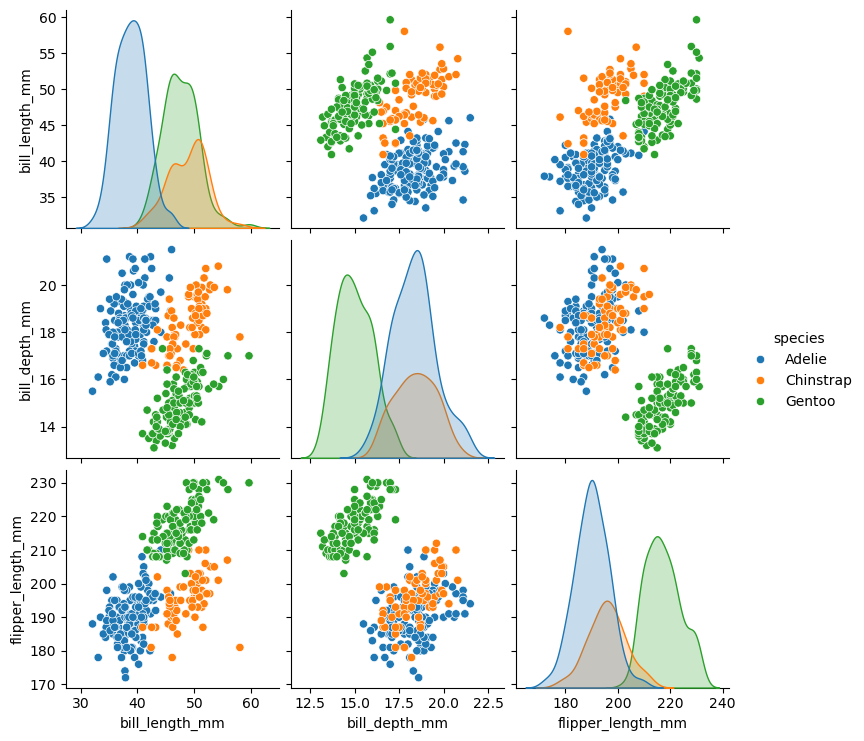

In [84]:
# Pairplot em relação as variáveis iniciais

sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'species']], hue='species');

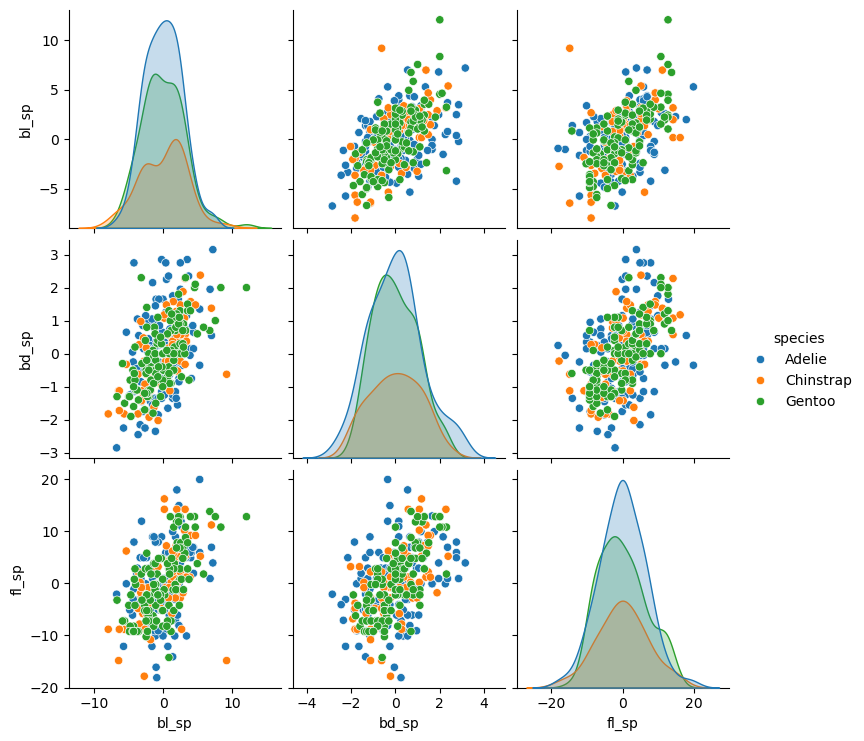

In [89]:
# Pairplot com as novas variáveis (diferenças)

# Note não há mais um dependência clara com a espécie 
sns.pairplot(penguins[['bl_sp', 'bd_sp', 'fl_sp', 'species']], hue='species');

> Os novos dados não possuem uma dependência clara com a `species`.

##### Criando o modelo de regressão com os "novos" dados

In [103]:
r1 = smf.ols("""body_mass_g ~
                species + sex 
                + bl_sp
                + bd_sp
                + fl_sp""", data=penguins).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     380.2
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          6.82e-144
Time:                        10:10:25   Log-Likelihood:                -2354.0
No. Observations:                 333   AIC:                             4722.
Df Residuals:                     326   BIC:                             4749.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3511.2186     33.732    104.091      0.000    3444.858    3577.579
species[T.Chinstrap]    26.9239     42.186      0.638      0.524     -56.068     109.915
species[T.Gentoo]     1381.3580     35.492     38.920      0.000    1311.536    1451.180
sex[T.Male]            389.8915     47.848      8.148      0.000     295.761     484.022
bl_sp                   18.2044      7.106      2.562      0.011       4.225      32.184
bd_sp                   67.2176     19.742      3.405      0.001      28.380     106.055
fl_sp                   15.9502      2.910      5.482      0.000      10.226      21.674
==============================================================================
Omnibus:                        0.879   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.871
Skew:                           0.124   Prob(JB):                        0.647
Kurtosis:                       2.959   Cond. No.                         24.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quanto maior os valores nos coeficientes das variáveis `bl_sp`, `bd_sp` e `fl_sp` maior será a massa do pinguim.

##### Verificando o vif (Variance Inflation Factor)

In [99]:
variaveis = ['species', 'island', 'sex', 'bl_sp', 'bd_sp', 'fl_sp']
peng_dum = pd.get_dummies(penguins[variaveis], drop_first=True,
                         dtype='float') # colocando o tipo das variáveis dummy
print(peng_dum.shape)
peng_dum.head()

(333, 8)


,bl_sp,bd_sp,fl_sp,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,0.276027,0.35274,-9.10274,0.0,0.0,0.0,1.0,1.0
1,0.676027,-0.94726,-4.10274,0.0,0.0,0.0,1.0,0.0
2,1.476027,-0.34726,4.89726,0.0,0.0,0.0,1.0,0.0
4,-2.123973,0.95274,2.89726,0.0,0.0,0.0,1.0,0.0
5,0.476027,2.25274,-0.10274,0.0,0.0,0.0,1.0,1.0


In [102]:
# VIF
vars_vif = pd.DataFrame()
vars_vif['VIF Factor'] = [vif(peng_dum, i) for i in range(peng_dum.shape[1])]
vars_vif['Feature'] = peng_dum.columns
vars_vif.round(2)

,VIF Factor,Feature
0,1.75,bl_sp
1,1.89,bd_sp
2,1.49,fl_sp
3,2.24,species_Chinstrap
4,1.67,species_Gentoo
5,3.04,island_Dream
6,1.21,island_Torgersen
7,3.59,sex_Male


> Obtivemos valores baixos para os vifs, ou seja, baixa colinearidade e obtivemos um ótimo e consistente modelo. O valor de R-quadrado se manteve e a legibilidade do modelo está excelente.
>
> **Desta forma, a construção de variáveis ortogonais é muito eficiente na redução da multicolinearidade e também na manutenção da legibilidade do modelo.**

In [119]:
penguins.sort_values(ascending=True, by='body_mass_g')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,bl_sp,bd_sp,fl_sp
190,Chinstrap,Dream,46.9,16.6,192.0,2700.0,Female,-1.933824,-1.820588,-3.823529
64,Adelie,Biscoe,36.4,17.1,184.0,2850.0,Female,-2.423973,-1.247260,-6.102740
58,Adelie,Biscoe,36.5,16.6,181.0,2850.0,Female,-2.323973,-1.747260,-9.102740
116,Adelie,Torgersen,38.6,17.0,188.0,2900.0,Female,-0.223973,-1.347260,-2.102740
98,Adelie,Dream,33.1,16.1,178.0,2900.0,Female,-5.723973,-2.247260,-12.102740
...,...,...,...,...,...,...,...,...,...,...
299,Gentoo,Biscoe,45.2,16.4,223.0,5950.0,Male,-2.368067,1.403361,5.764706
337,Gentoo,Biscoe,48.8,16.2,222.0,6000.0,Male,1.231933,1.203361,4.764706
297,Gentoo,Biscoe,51.1,16.3,220.0,6000.0,Male,3.531933,1.303361,2.764706
253,Gentoo,Biscoe,59.6,17.0,230.0,6050.0,Male,12.031933,2.003361,12.764706


## Referências

- <a id='neter2005'></a> "Applied Linear Statistical Models" de Michael H Kutner, Christopher J. Nachtsheim, John Neter e William Li. Ed. McGraw-Hill Irwin, 2005.<br>
    Este é um livro bem completo sobre modelos lineares, e bem acadêmico, diferente dos livros da Orelly, por exemplo, que são bem focados na prática.
    <br><br>
- [Supervisory Guidance on Model Risk Management](https://www.occ.gov/news-issuances/bulletins/2011/bulletin-2011-12a.pdf) PDF<br>
    Este é um artigo produzido pelos reguladores americanos, o OCC e o FED, que trata do tema *Risco de Modelos*. É um artigo bem focado na regulamentação do uso de modelos no mercado bancário, mas tem ideias muito interessantes para qualquer realidade - embora não seja obrigatória a validação de modelos em outros mercados.
    <br><br>
- Associação entre variáveis qualitativas:
    - Teste qui-quadrado [wikipedia](https://pt.wikipedia.org/wiki/Teste_qui-quadrado_de_Pearson)
    - V de Cramer [wikipedia](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)
    - V de Cramer [Journal of the Korean Statistical Society](https://www.sciencedirect.com/science/article/abs/pii/S1226319212001032)
    - V de Cramer no [Stack Overflow](https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix)
